In [1]:
import torch
from torch import argmax, argsort, relu
from torchvision.models import alexnet
from torchsummary import summary
from utils import classify
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from male import get_important_neurons

/home/adamwsl/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%load_ext autoreload

In [3]:
filename = 'lemon.jpg'

In [4]:
model = alexnet(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
if not os.path.exists(os.path.join('images', 'clipped', filename)):
    plt.imsave(os.path.join('images', 'clipped', filename), image_center_resized)

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'alexnet_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['conv5']
layer_map = {'conv1' : model.features[0], 
             'conv2' : model.features[3], 
             'conv3' : model.features[6], 
             'conv4' : model.features[8], 
             'conv5' : model.features[10]}

In [8]:
how_much_highest = 10

In [9]:
per_layer_results, per_layer_activations = get_important_neurons(how_much_highest, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [10]:
print(per_layer_results)

{'conv5': {114: 'Center part of flowers and flowers', 138: 'Animal heads', 117: 'Balls and other circles', 125: 'Dogs and guinea pig', 165: 'Birds', 14: 'Mugs and other containers', 45: 'Rounded edges in pictures', 42: 'The area around the object', 210: 'Stripes', 143: 'Animal heads'}}


In [11]:
print(categories[0])

mixing bowl


In [12]:
categories

array(['mixing bowl', 'face powder', 'Petri dish', 'soup bowl', 'lemon'],
      dtype='<U30')

In [13]:
from male import get_positions
per_layer_positions = get_positions(per_layer_results, per_layer_activations)

In [14]:
per_layer_positions

{'conv5': {114: ['left', 'right', 'bottom'],
  138: ['left', 'right', 'top', 'bottom', 'center'],
  117: ['right', 'top', 'center'],
  125: ['left', 'right', 'top', 'bottom'],
  165: ['left', 'right', 'top', 'bottom', 'center'],
  14: ['left', 'right', 'bottom', 'center'],
  45: ['left', 'right', 'top', 'bottom'],
  42: ['left', 'right', 'top', 'bottom'],
  210: ['left', 'right', 'top', 'bottom'],
  143: ['left', 'right', 'top', 'bottom']}}

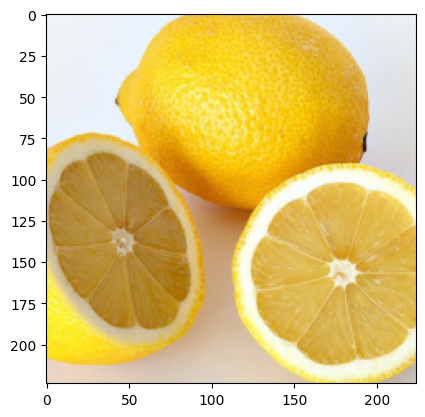

In [15]:
plt.imshow(image_center_resized)
plt.show()

In [16]:
%autoreload 2
from male import associate_channels
x = associate_channels(input_batch=input_batch, 
                       prev_layer=layer_map['conv4'], 
                       prev_out_channels=256,
                       curr_layer=layer_map['conv5'], 
                       target_ch_id=2, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[50, 19, 162, 242, 151, 17, 52, 12, 156, 116]


In [17]:
query = descriptions[descriptions['layer'] == 'conv4']
tops = list(torch.argsort(x).numpy())[:5]
print(tops)
query =  query[query['unit'].isin(tops)]
query.set_index('unit', inplace=True)
query = query.loc[tops]
query.reset_index(inplace=True)
query

[50, 19, 162, 242, 151]


,unit,layer,description
0,50,conv4,Faces
1,19,conv4,The top of the circle
2,162,conv4,Circles
3,242,conv4,The center part of a flower
4,151,conv4,Circles


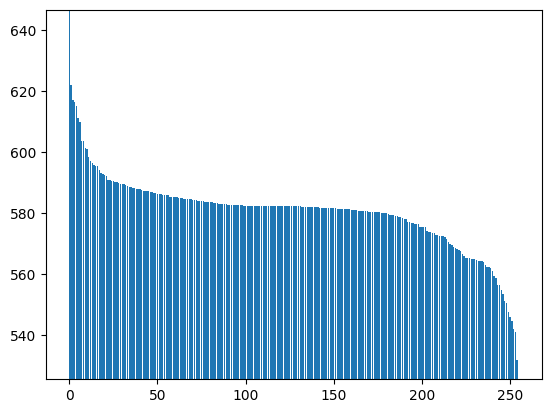

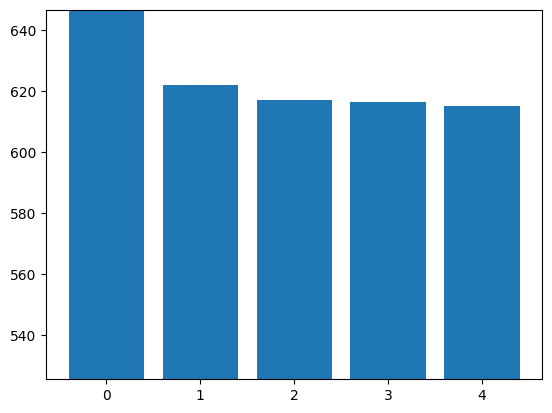

In [18]:
import matplotlib.pyplot as plt
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(y), max(y))
plt.bar(range(len(y[:5])), y[:5])
plt.show()